In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("../EDA/final_features_with_labels.csv")
print("Dataset shape:", df.shape)

# Drop 'phq8_score' (we're doing classification now)
df = df.drop(columns=['phq8_score'])

# Separate features and target
X = df.drop(columns=['participant_id', 'phq8_binary'])
y = df['phq8_binary']

# Check for missing values
print("Missing values in features:", X.isnull().sum().sum())
print("Missing values in target:", y.isnull().sum())

# Check class distribution
print("Class distribution:\n", y.value_counts())

Dataset shape: (78, 402)
Missing values in features: 0
Missing values in target: 0
Class distribution:
 phq8_binary
1    40
0    38
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split

# Stratified 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (62, 399)
Test size: (16, 399)


In [3]:
from sklearn.preprocessing import StandardScaler

# Identify embedding columns
embed_cols = [col for col in X.columns if col.startswith("embed_")]

# Initialize scaler
scaler = StandardScaler()

# Fit on training set, transform both sets
X_train[embed_cols] = scaler.fit_transform(X_train[embed_cols])
X_test[embed_cols] = scaler.transform(X_test[embed_cols])

**Logistic Regression**
Starting with simple model first

Accuracy: 0.5625
F1 Score: 0.5333333333333333
ROC AUC Score: 0.671875

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.57      0.50      0.53         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16



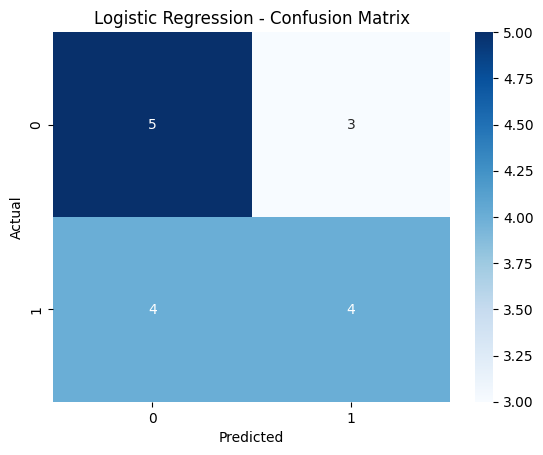

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


**Random Forest Classifier**

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Initialize model
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🎯 F1 Score:", f1_score(y_test, y_pred))
print("📈 ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🧱 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

🔍 Accuracy: 0.3125
🎯 F1 Score: 0.35294117647058826
📈 ROC AUC Score: 0.421875

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.25      0.27         8
           1       0.33      0.38      0.35         8

    accuracy                           0.31        16
   macro avg       0.31      0.31      0.31        16
weighted avg       0.31      0.31      0.31        16

🧱 Confusion Matrix:
 [[2 6]
 [5 3]]


**XG_Boost**

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Create the XGBoost model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Fit on training data
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

c:\Users\hp\Desktop\anxiety-model\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:43:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.3125
F1 Score: 0.26666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.29      0.25      0.27         8

    accuracy                           0.31        16
   macro avg       0.31      0.31      0.31        16
weighted avg       0.31      0.31      0.31        16


Confusion Matrix:
 [[3 5]
 [6 2]]


**Stratified K-fold**

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np


# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
accuracy_scores = []

fold = 1
for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # Scale inside fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Model
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    rf.fit(X_train_scaled, y_train_fold)
    y_pred = rf.predict(X_val_scaled)
    
    # Metrics
    f1 = f1_score(y_val_fold, y_pred)
    acc = accuracy_score(y_val_fold, y_pred)
    f1_scores.append(f1)
    accuracy_scores.append(acc)
    
    print(f"\n📂 Fold {fold}")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_val_fold, y_pred))
    
    fold += 1

print("\n==============================")
print("🔥 Mean F1 Score:", np.mean(f1_scores))
print("✅ Mean Accuracy:", np.mean(accuracy_scores))



📂 Fold 1
Accuracy: 0.4375
F1 Score: 0.47058823529411764
              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.44      0.50      0.47         8

    accuracy                           0.44        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.44      0.44      0.44        16


📂 Fold 2
Accuracy: 0.625
F1 Score: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.67      0.50      0.57         8

    accuracy                           0.62        16
   macro avg       0.63      0.62      0.62        16
weighted avg       0.63      0.62      0.62        16


📂 Fold 3
Accuracy: 0.5
F1 Score: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.50      0.38      0.43         8

    accuracy    